In [1]:
import os
import numpy as np
import rasterio
import matplotlib.image 

import matplotlib.pyplot as plt


In [2]:
files = {}
lens = {}

for f in os.listdir("data"):
    if ".jp2" in f and "_202203" in f:
        parts = f.split("_")
        if parts[0] not in files:
            files[parts[0]] = {}
        if parts[1] not in files[parts[0]]:
            files[parts[0]][parts[1]] = {}
        files[parts[0]][parts[1]][parts[2]] = f"data/{f}"

        if parts[1][:6] not in lens:
            lens[parts[1][:6]] = []
        lens[parts[1][:6]] = list(set(lens[parts[1][:6]]+[parts[0]]))


In [3]:
{k: len(v) for k,v in lens.items()} 


{'202203': 24}

In [4]:
len(lens)


1

In [5]:
# B04 and B08 for calculating NDVI => ((B08-B04)/(B08+B04))
# NDVI > 7 indicates presence of forest
# 
# https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/
#
# SCL for working out if what we're seeing is a cloud
# discard if SCL includes ones of invalid = [
#     0, // NO_DATA
#     1, // SATURATED_DEFECTIVE
#     3, // CLOUD_SHADOW
#     7, // CLOUD_LOW_PROBA
#     8, // CLOUD_MEDIUM_PROBA
#     9, // CLOUD_HIGH_PROBA
#     10 // THIN_CIRRUS
# ]

In [6]:
gain = 2

composites = {}

ct = 1
for ki, fi in files.items():
    print(ct, ki)
    #plt.subplot(5, 5, ct, title=ki)

    red = np.full((10980, 10980), -32768)
    green = np.full((10980, 10980), -32768)
    blue = np.full((10980, 10980), -32768)
    
    for kj, fj in fi.items():
        try:
            try:
                scl = np.repeat(np.repeat(rasterio.open(fj["SCL"], driver="JP2OpenJPEG").read(1), 2, 0), 2, 1)
            except BaseException as e:
                if os.path.isfile(fj["SCL"]):
                    print("REMOVED", fj["SCL"])
                    os.remove(fj["SCL"])
                raise e
            
            try:
                c_red = rasterio.open(fj["B04"], driver="JP2OpenJPEG").read(1)            
            except BaseException as e:
                if os.path.isfile(fj["B04"]):
                    print("REMOVED", fj["B04"])
                    os.remove(fj["B04"])
                raise e
            try:
                c_green = rasterio.open(fj["B03"], driver="JP2OpenJPEG").read(1)            
            except BaseException as e:
                if os.path.isfile(fj["B03"]):
                    print("REMOVED", fj["B03"])
                    os.remove(fj["B03"])
                raise e
            try:
                c_blue = rasterio.open(fj["B02"], driver="JP2OpenJPEG").read(1)            
            except BaseException as e:
                if os.path.isfile(fj["B02"]):
                    print("REMOVED", fj["B02"])
                    os.remove(fj["B02"])
                raise e
        
            #mask = ((scl != 0) & (scl != 1) & (scl != 3) & (scl != 7) & (scl != 8) & (scl != 9) & (scl != 10))
            mask = ((scl != 0) & (scl != 1))
            red[mask] = c_red[mask]
            green[mask] = c_green[mask]
            blue[mask] = c_blue[mask]
        except BaseException as e:
            print(f"ERROR: {ki} {kj} failed with {e}")

    rgb_composite = np.dstack((
        np.clip(red * gain / 10000, 0, 1), 
        np.clip(green * gain / 10000, 0, 1), 
        np.clip(blue * gain / 10000, 0, 1)
    ))
    composites[ki] = rgb_composite
    #plt.imshow(rgb_composite)
    ct += 1

#plt.show()


1 T35VNE
ERROR: T35VNE 20220322T093029 failed with 'B04'
ERROR: T35VNE 20220320T094031 failed with 'B03'
2 T35VND
3 T35VMC
4 T35ULB
5 T34UDG
6 T35VNC
7 T34VDH
8 T35UNB
9 T35UMB
10 T34VEH
11 T34VEJ
12 T34UEG
13 T35VME
14 T34VFJ
15 T35VLD
ERROR: T35VLD 20220323T095031 failed with 'B03'
16 T34VFK
17 T34VFH
18 T34VDK
19 T34VDJ
20 T34VEK
21 T35VLE
22 T34UFG
23 T35VMD
24 T35VLC


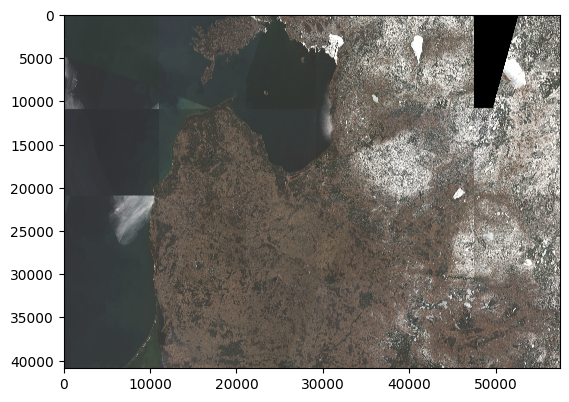

In [7]:
plt.imshow(
    np.concatenate((
        np.concatenate((
            np.concatenate((composites["T34VDK"], composites["T34VEK"][:,980:], composites["T34VFK"][:,980:]), axis=1),
            np.concatenate((composites["T34VDJ"], composites["T34VEJ"][:,980:], composites["T34VFJ"][:,980:]), axis=1)[980:,:],
            np.concatenate((composites["T34VDH"], composites["T34VEH"][:,980:], composites["T34VFH"][:,980:]), axis=1)[980:,:],
            np.concatenate((composites["T34UDG"], composites["T34UEG"][:,980:], composites["T34UFG"][:,980:]), axis=1)[980:,:]
        ), axis=0)[:-100,:-1900],
        np.concatenate((
            np.concatenate((composites["T35VLE"], composites["T35VME"][:,980:], composites["T35VNE"][:,980:]), axis=1),
            np.concatenate((composites["T35VLD"], composites["T35VMD"][:,980:], composites["T35VND"][:,980:]), axis=1)[980:,:],
            np.concatenate((composites["T35VLC"], composites["T35VMC"][:,980:], composites["T35VNC"][:,980:]), axis=1)[980:,:],
            np.concatenate((composites["T35ULB"], composites["T35UMB"][:,980:], composites["T35UNB"][:,980:]), axis=1)[980:,:]
        ), axis=0)[100:,2650:]
    ), axis=1)
)


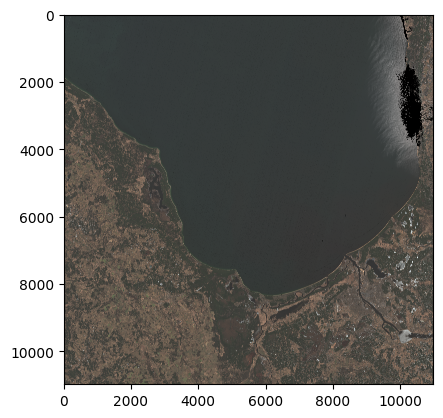

In [6]:
plt.imshow(composites["T34VFJ"])


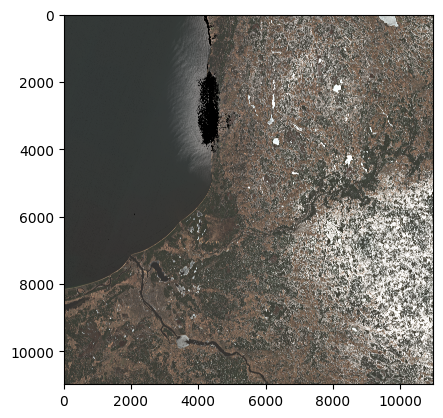

In [7]:
plt.imshow(composites["T35VLD"])


In [ ]:
plt.imshow(np.concatenate((composites["T34VFJ"][:-200,:-800],composites["T35VLD"][200:,3880:]), axis=1))


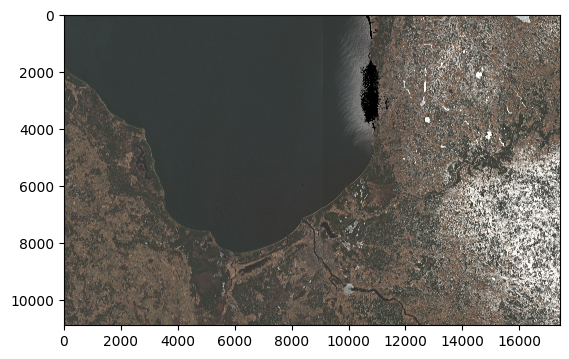

In [23]:
plt.imshow(np.concatenate((composites["T34VFJ"][:-100,:-1900],composites["T35VLD"][100:,2650:]), axis=1))


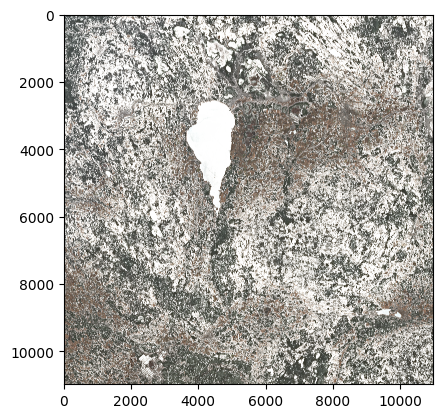

In [44]:
plt.imshow(composites["T35VME"])


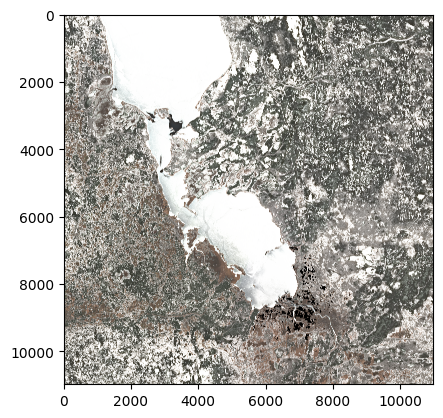

In [45]:
plt.imshow(composites["T35VNE"])


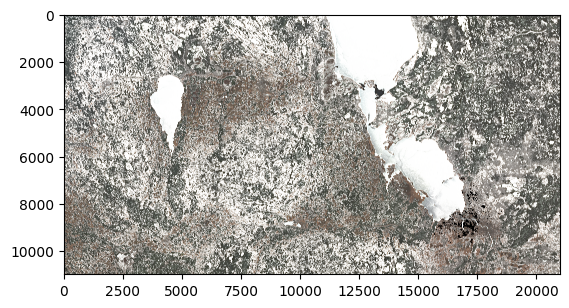

In [43]:
plt.imshow(np.concatenate((composites["T35VME"], composites["T35VNE"][:,980:]), axis=1))


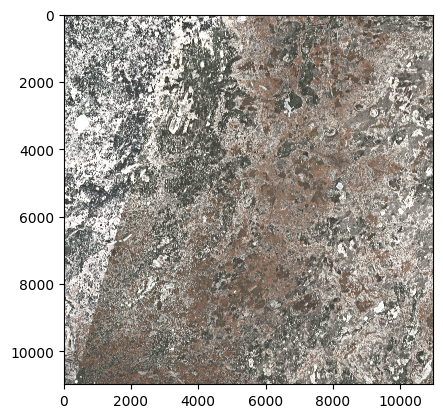

In [46]:
plt.imshow(composites["T35VND"])


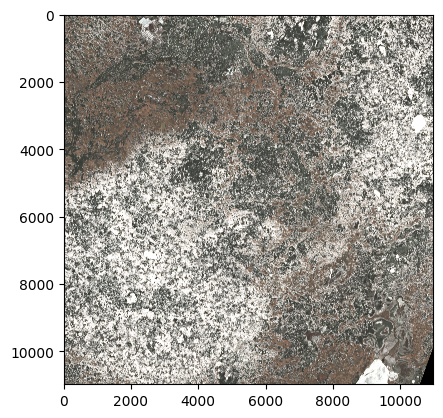

In [6]:
plt.imshow(composites["T35VMD"])


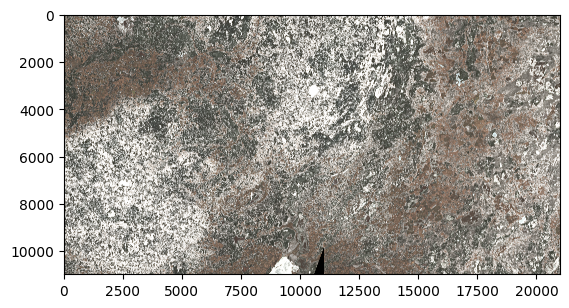

In [7]:
plt.imshow(np.concatenate((composites["T35VMD"], composites["T35VND"][:,980:]), axis=1))


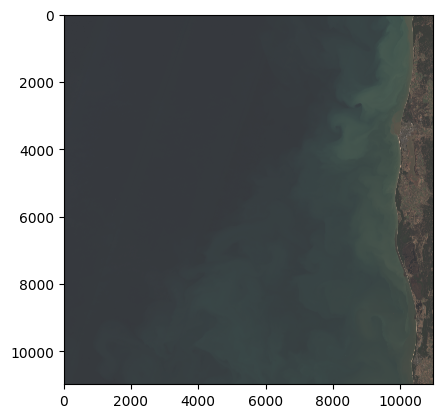

In [7]:
plt.imshow(composites["T34VDH"])


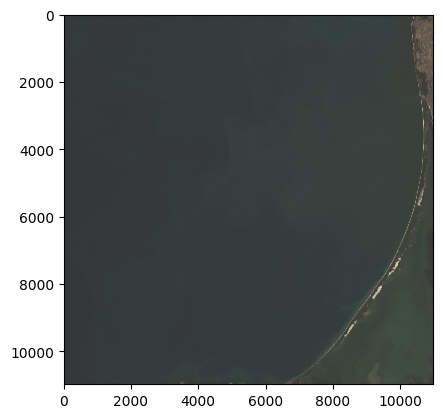

In [8]:
plt.imshow(composites["T34UDG"])


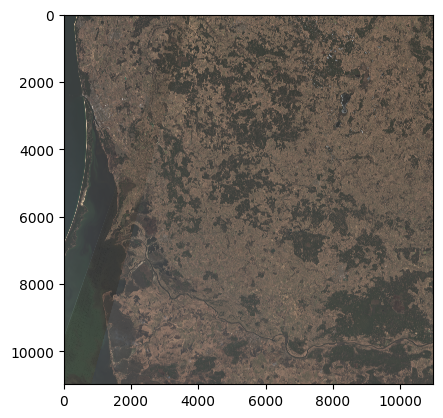

In [12]:
plt.imshow(composites["T34UEG"])


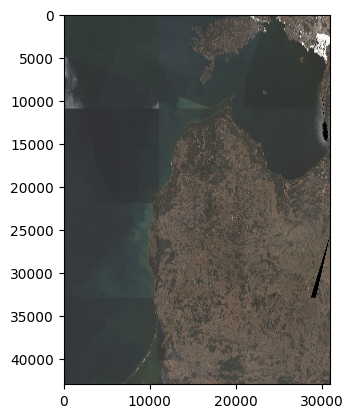

In [18]:
plt.imshow(np.concatenate((
    np.concatenate((composites["T34VDK"], composites["T34VEK"][:,980:], composites["T34VFK"][:,980:]), axis=1),
    np.concatenate((composites["T34VDJ"], composites["T34VEJ"][:,980:], composites["T34VFJ"][:,980:]), axis=1)[980:,:],
    np.concatenate((composites["T34VDH"], composites["T34VEH"][:,980:], composites["T34VFH"][:,980:]), axis=1)[980:,:],
    np.concatenate((composites["T34UDG"], composites["T34UEG"][:,980:], composites["T34UFG"][:,980:]), axis=1)[980:,:]
), axis=0))


In [6]:
sorted(list(composites.keys()))

['T34UDG',
 'T34UEG',
 'T34UFG',
 'T34VDH',
 'T34VDJ',
 'T34VDK',
 'T34VEH',
 'T34VEJ',
 'T34VEK',
 'T34VFH',
 'T34VFJ',
 'T34VFK',
 'T35ULB',
 'T35UMB',
 'T35UNB',
 'T35VLC',
 'T35VLD',
 'T35VLE',
 'T35VMC',
 'T35VMD',
 'T35VME',
 'T35VNC',
 'T35VND',
 'T35VNE']

In [ ]:
plt.imshow(
    np.concatenate((
        np.concatenate((
            np.concatenate((composites["T34VDK"], composites["T34VEK"][:,980:], composites["T34VFK"][:,980:]), axis=1),
            np.concatenate((composites["T34VDJ"], composites["T34VEJ"][:,980:], composites["T34VFJ"][:,980:]), axis=1)[980:,:],
            np.concatenate((composites["T34VDH"], composites["T34VEH"][:,980:], composites["T34VFH"][:,980:]), axis=1)[980:,:],
            np.concatenate((composites["T34UDG"], composites["T34UEG"][:,980:], composites["T34UFG"][:,980:]), axis=1)[980:,:]
        ), axis=0)[:-200,:-800],
        np.concatenate((
            np.concatenate((composites["T35VLE"], composites["T35VME"][:,980:], composites["T35VNE"][:,980:]), axis=1),
            np.concatenate((composites["T35VLD"], composites["T35VMD"][:,980:], composites["T35VND"][:,980:]), axis=1)[980:,:],
            np.concatenate((composites["T35VLC"], composites["T35VMC"][:,980:], composites["T35VNC"][:,980:]), axis=1)[980:,:],
            np.concatenate((composites["T35ULB"], composites["T35UMB"][:,980:], composites["T35UNB"][:,980:]), axis=1)[980:,:]
        ), axis=0)[200:,3880:]
    ), axis=1)
)
